## Group Information: To be filled by the candidates.

### Group Number: 11
### Members Roll Numbers: 20QM30001 and 20QM30004


In [1]:
# Install PyKEEN
!pip install pykeen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.5 MB/s eta 0:00:00


In [2]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
import pykeen.datasets as datasets
import matplotlib.pyplot as plt

INFO:pykeen.utils:Using opt_einsum


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Set seed for reproducibility
seed_value = 42
random.seed(seed_value)
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)

In [5]:
# Load the Nations dataset
nations_dataset = datasets.Nations()
nations_train_triples = nations_dataset.training.mapped_triples.to(device)
nations_valid_triples = nations_dataset.validation.mapped_triples.to(device)
nations_test_triples = nations_dataset.testing.mapped_triples.to(device)

In [ ]:
print("Nations dataset")
print("Training triples:", nations_train_triples.shape)
print("Validation triples:", nations_valid_triples.shape)
print("Testing triples:", nations_test_triples.shape)

Nations dataset
Training triples: torch.Size([1592, 3])
Validation triples: torch.Size([199, 3])
Testing triples: torch.Size([201, 3])


In [6]:
# Calculate relation-specific corruption probabilities for Bernoulli sampling
def calculate_relation_probabilities(triples):
    relation_head_count = defaultdict(int)
    relation_tail_count = defaultdict(int)
    for head, relation, tail in triples:
        relation_head_count[relation.item()] += 1
        relation_tail_count[relation.item()] += 1
    relation_probabilities = {}
    for relation in relation_head_count:
        head_count = relation_head_count[relation]
        tail_count = relation_tail_count[relation]
        total_count = head_count + tail_count
        head_prob = head_count / total_count if total_count > 0 else 0.5
        relation_probabilities[relation] = head_prob
    return relation_probabilities

In [ ]:
nations_relation_probabilities = calculate_relation_probabilities(nations_train_triples)
print("Calculated relation corruption probabilities:")
for relation, prob in nations_relation_probabilities.items():
    print(f"Relation {relation}: {prob:.2f} probability of corrupting the head.")

Calculated relation corruption probabilities:
Relation 3: 0.50 probability of corrupting the head.
Relation 4: 0.50 probability of corrupting the head.
Relation 6: 0.50 probability of corrupting the head.
Relation 7: 0.50 probability of corrupting the head.
Relation 8: 0.50 probability of corrupting the head.
Relation 9: 0.50 probability of corrupting the head.
Relation 13: 0.50 probability of corrupting the head.
Relation 14: 0.50 probability of corrupting the head.
Relation 15: 0.50 probability of corrupting the head.
Relation 18: 0.50 probability of corrupting the head.
Relation 19: 0.50 probability of corrupting the head.
Relation 20: 0.50 probability of corrupting the head.
Relation 21: 0.50 probability of corrupting the head.
Relation 24: 0.50 probability of corrupting the head.
Relation 25: 0.50 probability of corrupting the head.
Relation 27: 0.50 probability of corrupting the head.
Relation 28: 0.50 probability of corrupting the head.
Relation 29: 0.50 probability of corruptin

In [19]:
# Custom TransE Model Definition
class TransE(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim, margin, norm=1):
        super(TransE, self).__init__()
        self.embedding_dim = embedding_dim
        self.margin = margin
        self.norm = norm

        # Initialize entity and relation embeddings
        self.entity_embeddings = nn.Embedding(num_entities, embedding_dim)
        self.relation_embeddings = nn.Embedding(num_relations, embedding_dim)

        # Initialize embeddings uniformly
        nn.init.uniform_(self.entity_embeddings.weight, -6 / embedding_dim**0.5, 6 / embedding_dim**0.5)
        nn.init.uniform_(self.relation_embeddings.weight, -6 / embedding_dim**0.5, 6 / embedding_dim**0.5)

    def forward(self, positive_triples, negative_triples):
        pos_scores = self._compute_scores(positive_triples)
        neg_scores = self._compute_scores(negative_triples)

        # Margin ranking loss
        return torch.mean(torch.relu(self.margin + pos_scores - neg_scores))

    def _compute_scores(self, triples):
        head_embeddings = self.entity_embeddings(triples[:, 0])
        relation_embeddings = self.relation_embeddings(triples[:, 1])
        tail_embeddings = self.entity_embeddings(triples[:, 2])

        # TransE scoring function: ||h + r - t|| (L1 or L2 norm)
        scores = torch.norm(head_embeddings + relation_embeddings - tail_embeddings, p=self.norm, dim=1)
        return scores


In [20]:
# Custom Bernoulli Negative Sampler
class CustomBernoulliNegativeSampler:
    def __init__(self, triples, relation_probabilities):
        self.triples = triples
        self.relation_probabilities = relation_probabilities

    def sample(self, positive_batch):
        negative_triples = []
        for head, relation, tail in positive_batch:
            corrupt_head_prob = self.relation_probabilities[relation.item()]
            if random.random() < corrupt_head_prob:
                # Corrupt the head entity
                new_head = random.choice([h for h, _, _ in self.triples])
                negative_triples.append([new_head, relation, tail])
            else:
                # Corrupt the tail entity
                new_tail = random.choice([t for _, _, t in self.triples])
                negative_triples.append([head, relation, new_tail])
        return torch.tensor(negative_triples, device=device)

In [21]:
# Function to perform head and tail prediction, compute ranking metrics, and visualize results
def head_tail_prediction(model, test_triples, num_entities, device):
    head_ranks = []
    tail_ranks = []

    with torch.no_grad():
        for triple in test_triples:
            head, relation, tail = triple.tolist()

            # Head Prediction
            head_batch = torch.stack([torch.tensor([entity, relation, tail], device=device) for entity in range(num_entities)])
            head_scores = model._compute_scores(head_batch)  # Compute scores with varying heads
            sorted_head_indices = torch.argsort(head_scores, descending=False)  # Sort by ascending distance for TransE

            # Get the rank of the correct head entity
            correct_head_rank = (sorted_head_indices == head).nonzero(as_tuple=True)[0].item() + 1
            head_ranks.append(correct_head_rank)

            # Tail Prediction
            tail_batch = torch.stack([torch.tensor([head, relation, entity], device=device) for entity in range(num_entities)])
            tail_scores = model._compute_scores(tail_batch)  # Compute scores with varying tails
            sorted_tail_indices = torch.argsort(tail_scores, descending=False)

            # Get the rank of the correct tail entity
            correct_tail_rank = (sorted_tail_indices == tail).nonzero(as_tuple=True)[0].item() + 1
            tail_ranks.append(correct_tail_rank)

    # Compute Mean Rank and Hits@10 for head and tail predictions
    mean_rank_head = sum(head_ranks) / len(head_ranks)
    mean_rank_tail = sum(tail_ranks) / len(tail_ranks)
    hits_at_10_head = sum(rank <= 10 for rank in head_ranks) / len(head_ranks)
    hits_at_10_tail = sum(rank <= 10 for rank in tail_ranks) / len(tail_ranks)

    # Print the computed metrics
    print(f"\nHead Prediction - Mean Rank: {mean_rank_head}, Hits@10: {hits_at_10_head}")
    print(f"Tail Prediction - Mean Rank: {mean_rank_tail}, Hits@10: {hits_at_10_tail}")

    # Visualize rank distributions and metrics
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Histogram for head ranks
    axs[0, 0].hist(head_ranks, bins=50, color='skyblue', edgecolor='black')
    axs[0, 0].set_title("Head Prediction Rank Distribution")
    axs[0, 0].set_xlabel("Rank")
    axs[0, 0].set_ylabel("Frequency")

    # Histogram for tail ranks
    axs[0, 1].hist(tail_ranks, bins=50, color='salmon', edgecolor='black')
    axs[0, 1].set_title("Tail Prediction Rank Distribution")
    axs[0, 1].set_xlabel("Rank")
    axs[0, 1].set_ylabel("Frequency")

    # Bar plot for Mean Rank comparison
    axs[1, 0].bar(['Head Mean Rank', 'Tail Mean Rank'], [mean_rank_head, mean_rank_tail], color=['skyblue', 'salmon'])
    axs[1, 0].set_title("Mean Rank for Head and Tail Predictions")
    axs[1, 0].set_ylabel("Mean Rank")

    # Bar plot for Hits@10 comparison
    axs[1, 1].bar(['Head Hits@10', 'Tail Hits@10'], [hits_at_10_head, hits_at_10_tail], color=['skyblue', 'salmon'])
    axs[1, 1].set_title("Hits@10 for Head and Tail Predictions")
    axs[1, 1].set_ylabel("Hits@10")

    plt.tight_layout()
    plt.show()

In [10]:
# Parameters
embedding_dim = 100
learning_rate = 0.001
epochs = 50
batch_size = 64


Training TransE on Nations with margin: 1
Epoch 1/50, Margin 1, Loss: 3.5452
Epoch 2/50, Margin 1, Loss: 3.8126
Epoch 3/50, Margin 1, Loss: 3.4256
Epoch 4/50, Margin 1, Loss: 3.2999
Epoch 5/50, Margin 1, Loss: 3.1421
Epoch 6/50, Margin 1, Loss: 3.0031
Epoch 7/50, Margin 1, Loss: 3.0523
Epoch 8/50, Margin 1, Loss: 2.8040
Epoch 9/50, Margin 1, Loss: 2.6926
Epoch 10/50, Margin 1, Loss: 2.7039
Epoch 11/50, Margin 1, Loss: 2.6811
Epoch 12/50, Margin 1, Loss: 2.3855
Epoch 13/50, Margin 1, Loss: 2.3187
Epoch 14/50, Margin 1, Loss: 2.5341
Epoch 15/50, Margin 1, Loss: 2.4573
Epoch 16/50, Margin 1, Loss: 2.2619
Epoch 17/50, Margin 1, Loss: 2.2411
Epoch 18/50, Margin 1, Loss: 2.2162
Epoch 19/50, Margin 1, Loss: 2.1462
Epoch 20/50, Margin 1, Loss: 1.9036
Epoch 21/50, Margin 1, Loss: 1.9097
Epoch 22/50, Margin 1, Loss: 1.9448
Epoch 23/50, Margin 1, Loss: 1.9503
Epoch 24/50, Margin 1, Loss: 1.8620
Epoch 25/50, Margin 1, Loss: 1.7669
Epoch 26/50, Margin 1, Loss: 1.7152
Epoch 27/50, Margin 1, Loss: 1

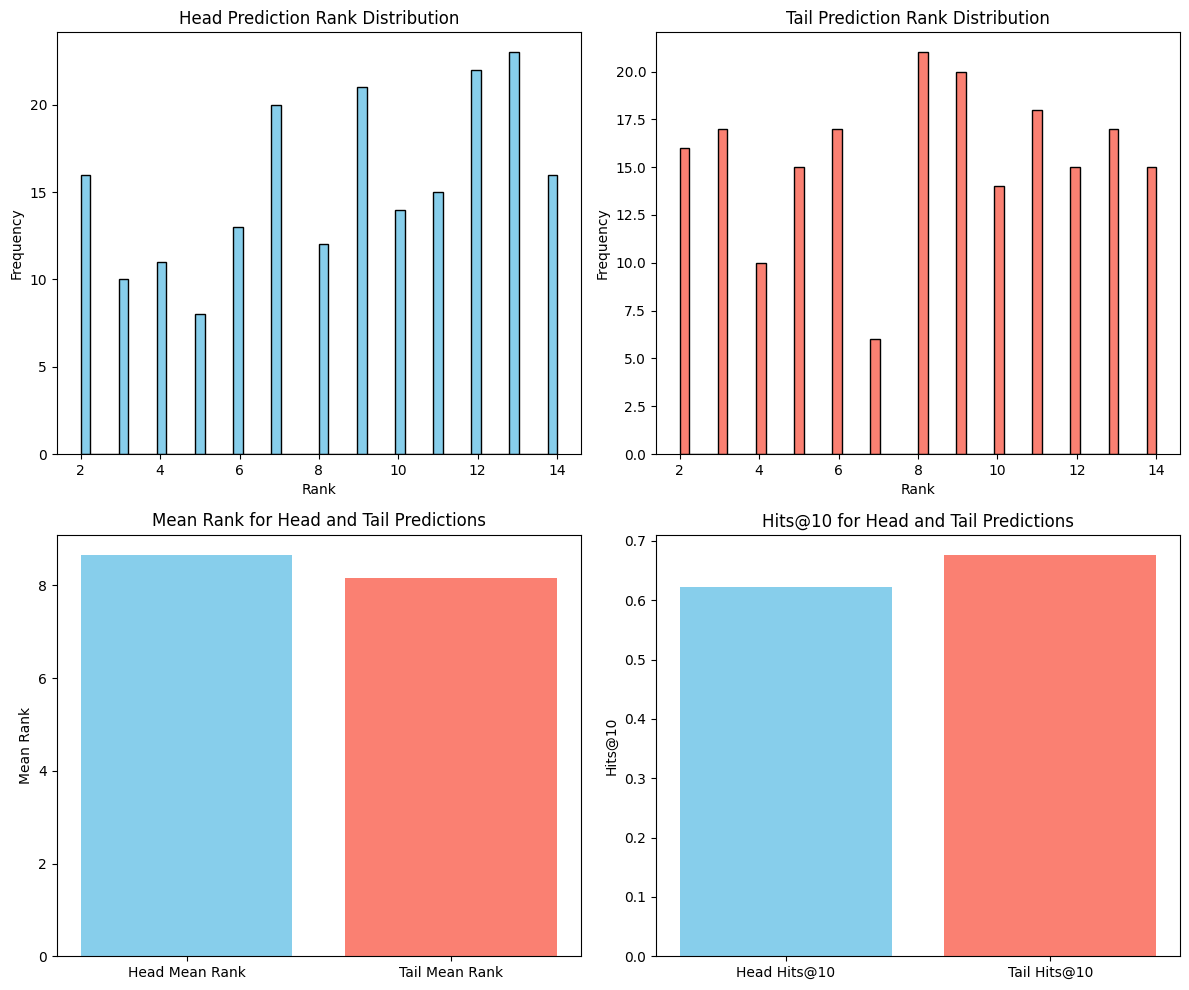


Training TransE on Nations with margin: 2
Epoch 1/50, Margin 2, Loss: 4.4920
Epoch 2/50, Margin 2, Loss: 4.1486
Epoch 3/50, Margin 2, Loss: 3.9137
Epoch 4/50, Margin 2, Loss: 3.8586
Epoch 5/50, Margin 2, Loss: 3.7149
Epoch 6/50, Margin 2, Loss: 3.6070
Epoch 7/50, Margin 2, Loss: 3.7262
Epoch 8/50, Margin 2, Loss: 3.5612
Epoch 9/50, Margin 2, Loss: 3.5351
Epoch 10/50, Margin 2, Loss: 3.4904
Epoch 11/50, Margin 2, Loss: 3.4396
Epoch 12/50, Margin 2, Loss: 3.1272
Epoch 13/50, Margin 2, Loss: 3.1247
Epoch 14/50, Margin 2, Loss: 3.0641
Epoch 15/50, Margin 2, Loss: 3.0676
Epoch 16/50, Margin 2, Loss: 3.0674
Epoch 17/50, Margin 2, Loss: 3.1370
Epoch 18/50, Margin 2, Loss: 2.9956
Epoch 19/50, Margin 2, Loss: 2.9589
Epoch 20/50, Margin 2, Loss: 2.8506
Epoch 21/50, Margin 2, Loss: 2.6726
Epoch 22/50, Margin 2, Loss: 2.6906
Epoch 23/50, Margin 2, Loss: 2.4792
Epoch 24/50, Margin 2, Loss: 2.7381
Epoch 25/50, Margin 2, Loss: 2.5837
Epoch 26/50, Margin 2, Loss: 2.5693
Epoch 27/50, Margin 2, Loss: 2

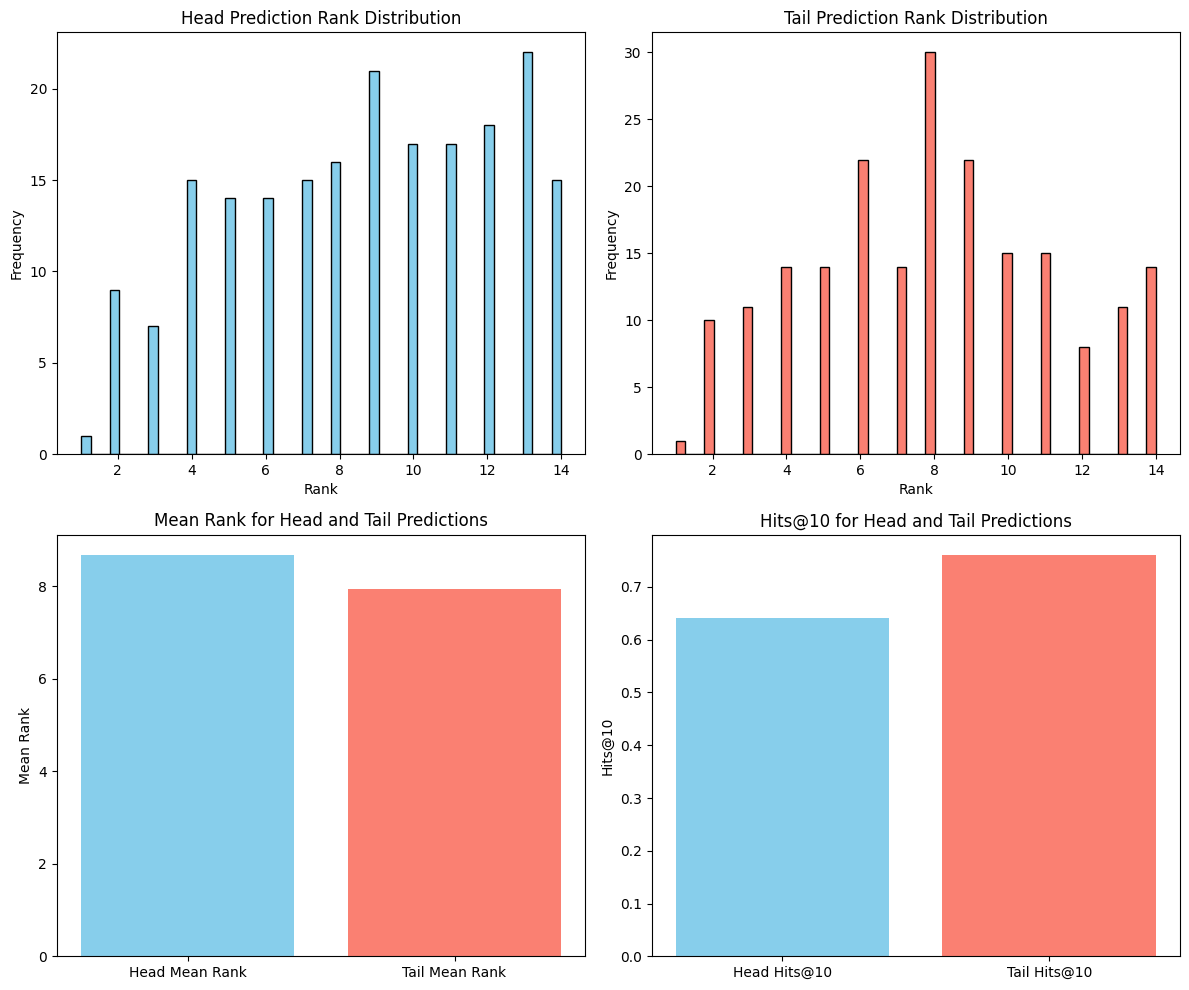


Training TransE on Nations with margin: 3
Epoch 1/50, Margin 3, Loss: 4.8465
Epoch 2/50, Margin 3, Loss: 5.0929
Epoch 3/50, Margin 3, Loss: 4.7504
Epoch 4/50, Margin 3, Loss: 4.7230
Epoch 5/50, Margin 3, Loss: 4.6687
Epoch 6/50, Margin 3, Loss: 4.4284
Epoch 7/50, Margin 3, Loss: 4.4157
Epoch 8/50, Margin 3, Loss: 4.2562
Epoch 9/50, Margin 3, Loss: 4.5037
Epoch 10/50, Margin 3, Loss: 4.0840
Epoch 11/50, Margin 3, Loss: 3.9552
Epoch 12/50, Margin 3, Loss: 4.0707
Epoch 13/50, Margin 3, Loss: 3.9406
Epoch 14/50, Margin 3, Loss: 3.9583
Epoch 15/50, Margin 3, Loss: 3.8651
Epoch 16/50, Margin 3, Loss: 3.9502
Epoch 17/50, Margin 3, Loss: 3.8225
Epoch 18/50, Margin 3, Loss: 3.8624
Epoch 19/50, Margin 3, Loss: 3.5995
Epoch 20/50, Margin 3, Loss: 3.8368
Epoch 21/50, Margin 3, Loss: 3.7355
Epoch 22/50, Margin 3, Loss: 3.4504
Epoch 23/50, Margin 3, Loss: 3.6100
Epoch 24/50, Margin 3, Loss: 3.4228
Epoch 25/50, Margin 3, Loss: 3.4191
Epoch 26/50, Margin 3, Loss: 3.4858
Epoch 27/50, Margin 3, Loss: 3

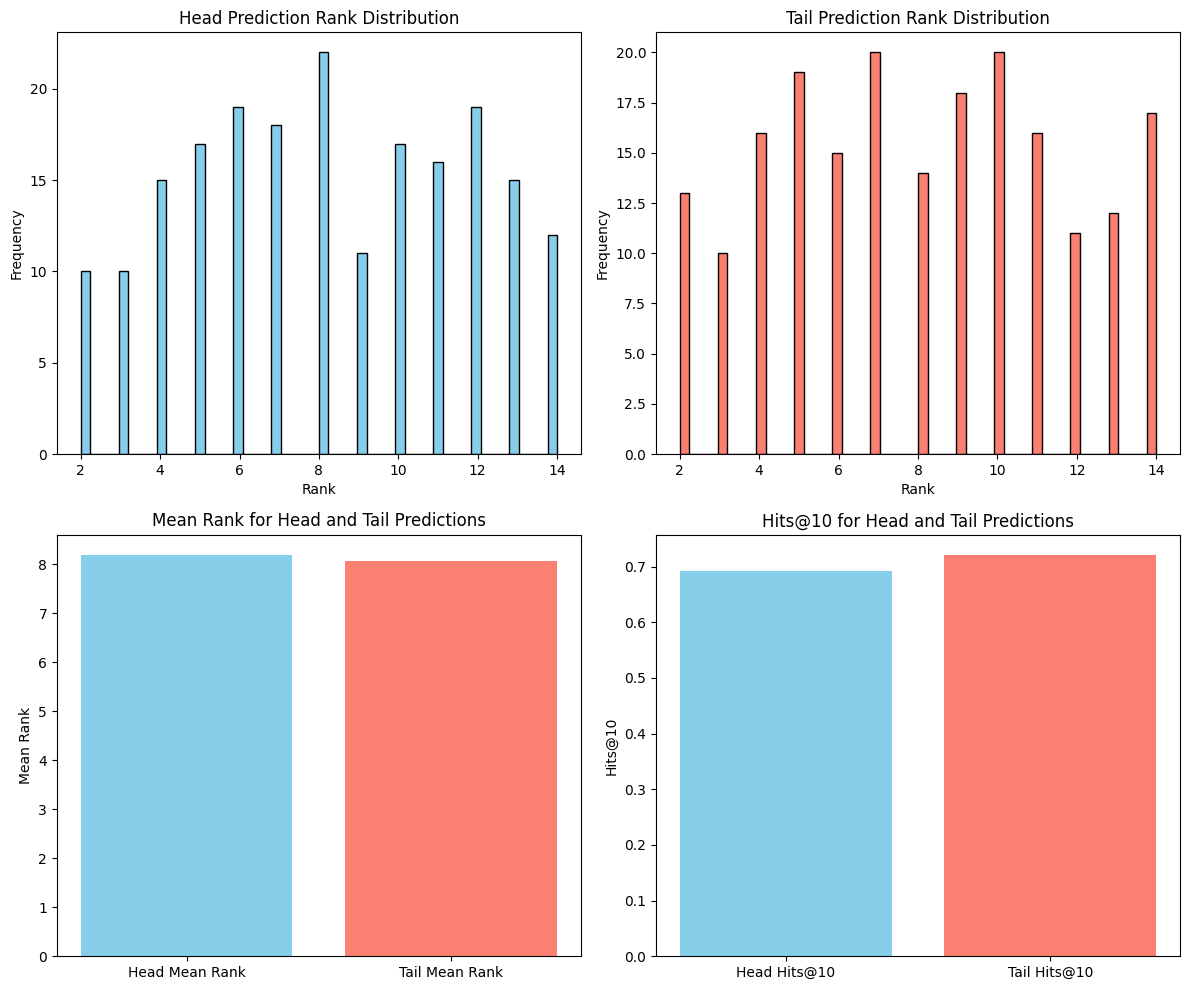


Training TransE on Nations with margin: 4
Epoch 1/50, Margin 4, Loss: 6.1467
Epoch 2/50, Margin 4, Loss: 5.7376
Epoch 3/50, Margin 4, Loss: 5.7375
Epoch 4/50, Margin 4, Loss: 5.6294
Epoch 5/50, Margin 4, Loss: 5.4677
Epoch 6/50, Margin 4, Loss: 5.5334
Epoch 7/50, Margin 4, Loss: 5.5555
Epoch 8/50, Margin 4, Loss: 5.3940
Epoch 9/50, Margin 4, Loss: 5.1817
Epoch 10/50, Margin 4, Loss: 5.1427
Epoch 11/50, Margin 4, Loss: 4.8768
Epoch 12/50, Margin 4, Loss: 5.0729
Epoch 13/50, Margin 4, Loss: 4.8676
Epoch 14/50, Margin 4, Loss: 4.7037
Epoch 15/50, Margin 4, Loss: 4.8092
Epoch 16/50, Margin 4, Loss: 4.7477
Epoch 17/50, Margin 4, Loss: 4.7773
Epoch 18/50, Margin 4, Loss: 4.5511
Epoch 19/50, Margin 4, Loss: 4.5115
Epoch 20/50, Margin 4, Loss: 4.5908
Epoch 21/50, Margin 4, Loss: 4.7438
Epoch 22/50, Margin 4, Loss: 4.5166
Epoch 23/50, Margin 4, Loss: 4.3018
Epoch 24/50, Margin 4, Loss: 4.6655
Epoch 25/50, Margin 4, Loss: 4.3578
Epoch 26/50, Margin 4, Loss: 4.3682
Epoch 27/50, Margin 4, Loss: 4

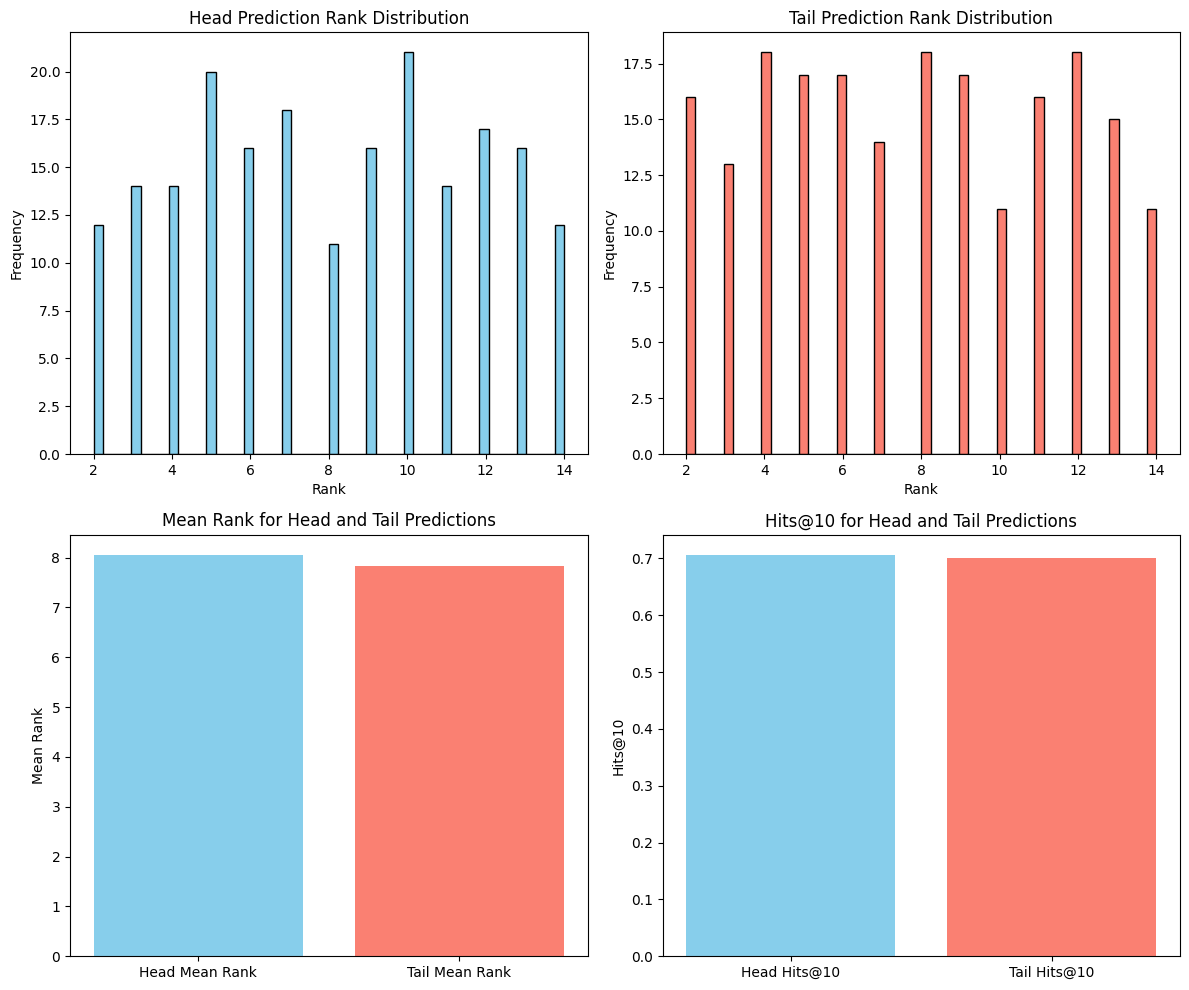


Training TransE on Nations with margin: 5
Epoch 1/50, Margin 5, Loss: 7.0783
Epoch 2/50, Margin 5, Loss: 6.9641
Epoch 3/50, Margin 5, Loss: 6.5742
Epoch 4/50, Margin 5, Loss: 6.5061
Epoch 5/50, Margin 5, Loss: 6.5508
Epoch 6/50, Margin 5, Loss: 6.4260
Epoch 7/50, Margin 5, Loss: 6.5159
Epoch 8/50, Margin 5, Loss: 6.4236
Epoch 9/50, Margin 5, Loss: 6.3710
Epoch 10/50, Margin 5, Loss: 6.5123
Epoch 11/50, Margin 5, Loss: 5.8474
Epoch 12/50, Margin 5, Loss: 5.8601
Epoch 13/50, Margin 5, Loss: 5.9371
Epoch 14/50, Margin 5, Loss: 5.8005
Epoch 15/50, Margin 5, Loss: 5.8414
Epoch 16/50, Margin 5, Loss: 5.9998
Epoch 17/50, Margin 5, Loss: 5.8957
Epoch 18/50, Margin 5, Loss: 5.6578
Epoch 19/50, Margin 5, Loss: 5.6921
Epoch 20/50, Margin 5, Loss: 5.4522
Epoch 21/50, Margin 5, Loss: 5.7334
Epoch 22/50, Margin 5, Loss: 5.5093
Epoch 23/50, Margin 5, Loss: 5.3750
Epoch 24/50, Margin 5, Loss: 5.2937
Epoch 25/50, Margin 5, Loss: 5.3342
Epoch 26/50, Margin 5, Loss: 5.2139
Epoch 27/50, Margin 5, Loss: 5

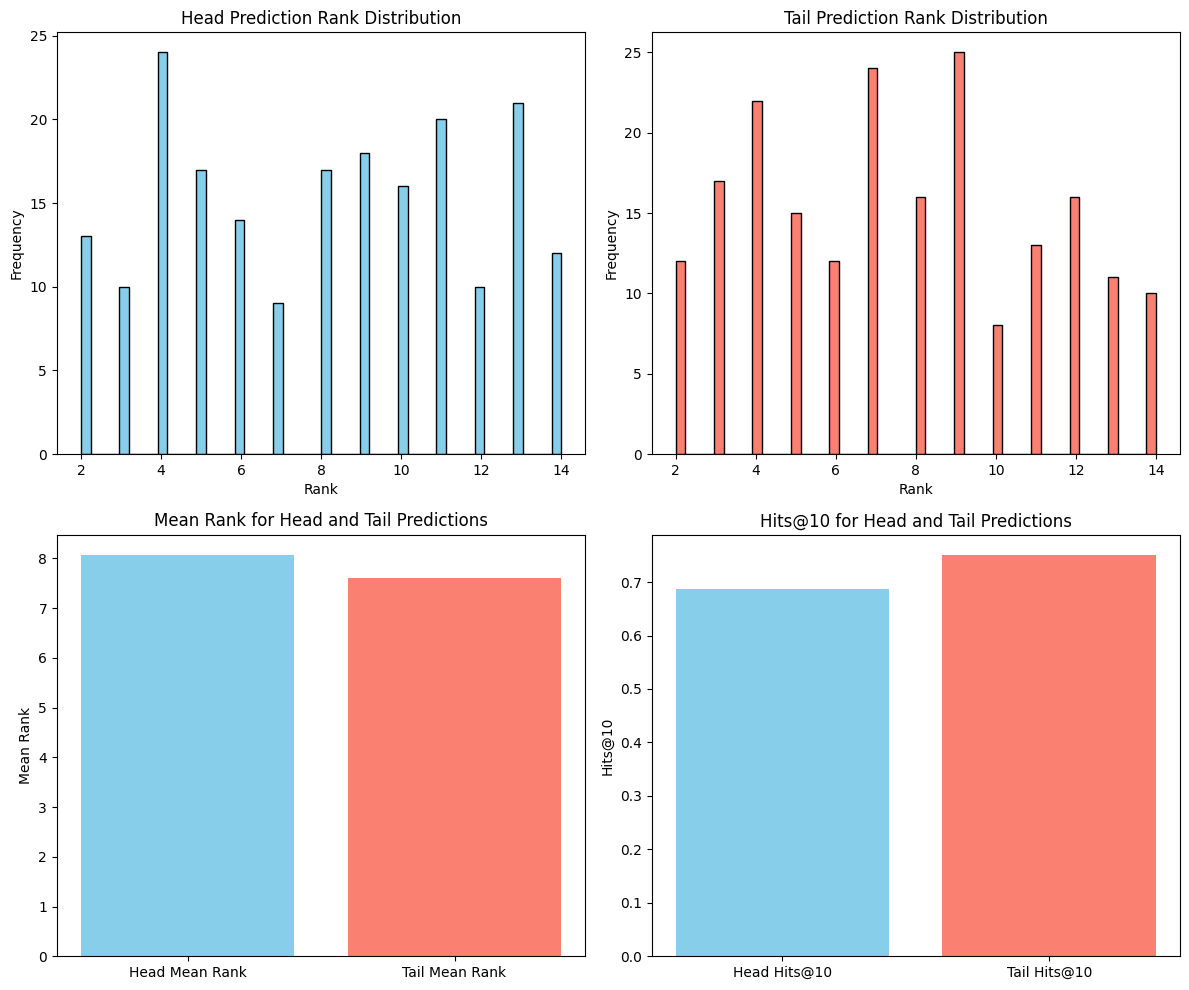


TransE training on Nations completed.


In [ ]:
# Training loop with margin values 1 to 5
negative_sampler = CustomBernoulliNegativeSampler(nations_train_triples, nations_relation_probabilities)

for margin in range(1, 6):
    print(f"\nTraining TransE on Nations with margin: {margin}")

    # Define TransE model
    trans_e_model = TransE(
        num_entities=nations_dataset.num_entities,
        num_relations=nations_dataset.num_relations,
        embedding_dim=embedding_dim,
        margin=margin,
        norm=1
    ).to(device)

    # Optimizer
    optimizer = torch.optim.Adam(trans_e_model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        trans_e_model.train()

        # Shuffle and batch the training triples
        indices = torch.randperm(nations_train_triples.size(0))
        epoch_loss = 0.0

        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            positive_batch = nations_train_triples[batch_indices]
            negative_batch = negative_sampler.sample(positive_batch).to(device)

            # Forward pass and loss calculation
            optimizer.zero_grad()
            loss = trans_e_model(positive_batch, negative_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        num_batches = len(indices) // batch_size
        print(f"Epoch {epoch + 1}/{epochs}, Margin {margin}, Loss: {epoch_loss / num_batches:.4f}")

    # Model evaluation part
    transE_nations_results = head_tail_prediction(trans_e_model, nations_test_triples, nations_dataset.num_entities, device)



print("\nTransE training on Nations completed.")

**Building TransR class in a similar manner as that of TransE class**

In [11]:
class TransR(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim, margin, proj_dim, norm=1):
        super(TransR, self).__init__()
        self.embedding_dim = embedding_dim
        self.proj_dim = proj_dim
        self.margin = margin
        self.norm = norm

        # Initialize entity, relation, and projection embeddings
        self.entity_embeddings = nn.Embedding(num_entities, embedding_dim)
        self.relation_embeddings = nn.Embedding(num_relations, proj_dim)
        self.projection_matrices = nn.Embedding(num_relations, embedding_dim * proj_dim)

        # Initialize embeddings and projection matrices uniformly
        nn.init.uniform_(self.entity_embeddings.weight, -6 / embedding_dim**0.5, 6 / embedding_dim**0.5)
        nn.init.uniform_(self.relation_embeddings.weight, -6 / proj_dim**0.5, 6 / proj_dim**0.5)
        nn.init.uniform_(self.projection_matrices.weight, -6 / (embedding_dim * proj_dim)**0.5, 6 / (embedding_dim * proj_dim)**0.5)

    def forward(self, positive_triples, negative_triples):
        pos_scores = self._compute_scores(positive_triples)
        neg_scores = self._compute_scores(negative_triples)

        # Margin ranking loss
        return torch.mean(torch.relu(self.margin + pos_scores - neg_scores))

    def _compute_scores(self, triples):
        head_embeddings = self.entity_embeddings(triples[:, 0])
        relation_embeddings = self.relation_embeddings(triples[:, 1])
        tail_embeddings = self.entity_embeddings(triples[:, 2])

        # Project entities into relation-specific space
        proj_matrix = self.projection_matrices(triples[:, 1]).view(-1, self.embedding_dim, self.proj_dim)
        head_proj = torch.bmm(head_embeddings.unsqueeze(1), proj_matrix).squeeze(1)
        tail_proj = torch.bmm(tail_embeddings.unsqueeze(1), proj_matrix).squeeze(1)

        # TransR scoring function: ||h_r + r - t_r|| (L1 or L2 norm)
        scores = torch.norm(head_proj + relation_embeddings - tail_proj, p=self.norm, dim=1)
        return scores


In [ ]:
# Parameters specific to TransR
embedding_dim = 100
proj_dim = 100  # Dimension after projection
learning_rate = 0.001
epochs = 50
batch_size = 64


Training TransR on Nations with margin: 1
Epoch 1/50, Margin 1, Loss: 1.8321
Epoch 2/50, Margin 1, Loss: 1.5946
Epoch 3/50, Margin 1, Loss: 1.4194
Epoch 4/50, Margin 1, Loss: 1.4070
Epoch 5/50, Margin 1, Loss: 1.3530
Epoch 6/50, Margin 1, Loss: 1.3010
Epoch 7/50, Margin 1, Loss: 1.3399
Epoch 8/50, Margin 1, Loss: 1.2264
Epoch 9/50, Margin 1, Loss: 1.2394
Epoch 10/50, Margin 1, Loss: 1.2317
Epoch 11/50, Margin 1, Loss: 1.1408
Epoch 12/50, Margin 1, Loss: 1.1044
Epoch 13/50, Margin 1, Loss: 1.1229
Epoch 14/50, Margin 1, Loss: 1.1837
Epoch 15/50, Margin 1, Loss: 1.1696
Epoch 16/50, Margin 1, Loss: 1.0587
Epoch 17/50, Margin 1, Loss: 1.1321
Epoch 18/50, Margin 1, Loss: 1.0875
Epoch 19/50, Margin 1, Loss: 1.1275
Epoch 20/50, Margin 1, Loss: 1.0497
Epoch 21/50, Margin 1, Loss: 1.0472
Epoch 22/50, Margin 1, Loss: 0.9990
Epoch 23/50, Margin 1, Loss: 1.0186
Epoch 24/50, Margin 1, Loss: 1.0274
Epoch 25/50, Margin 1, Loss: 1.0617
Epoch 26/50, Margin 1, Loss: 0.9492
Epoch 27/50, Margin 1, Loss: 0

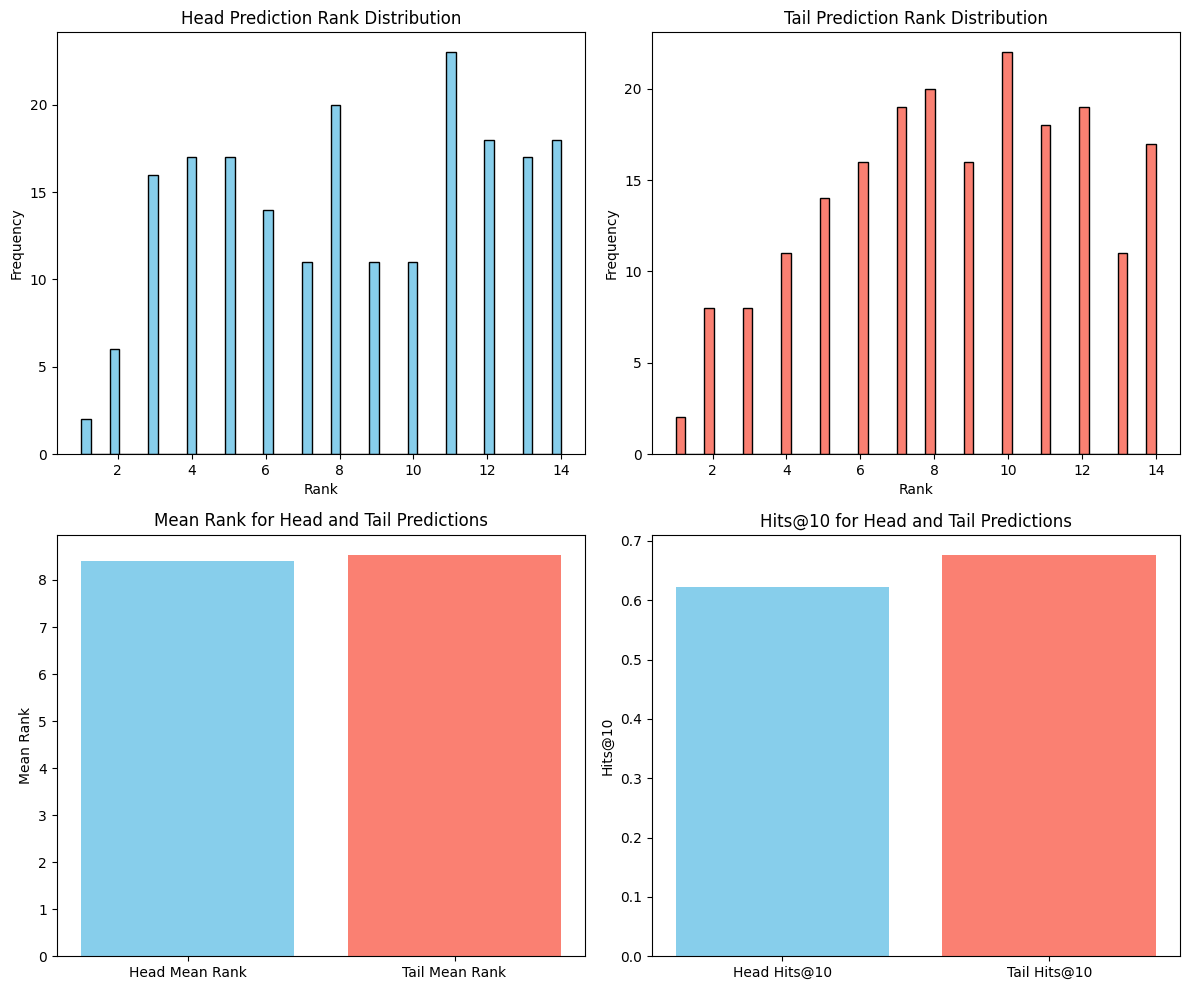


Training TransR on Nations with margin: 2
Epoch 1/50, Margin 2, Loss: 2.8400
Epoch 2/50, Margin 2, Loss: 2.3102
Epoch 3/50, Margin 2, Loss: 2.1253
Epoch 4/50, Margin 2, Loss: 2.0904
Epoch 5/50, Margin 2, Loss: 1.9567
Epoch 6/50, Margin 2, Loss: 2.0432
Epoch 7/50, Margin 2, Loss: 1.9331
Epoch 8/50, Margin 2, Loss: 1.8535
Epoch 9/50, Margin 2, Loss: 1.8146
Epoch 10/50, Margin 2, Loss: 1.7601
Epoch 11/50, Margin 2, Loss: 1.7602
Epoch 12/50, Margin 2, Loss: 1.6829
Epoch 13/50, Margin 2, Loss: 1.7167
Epoch 14/50, Margin 2, Loss: 1.7117
Epoch 15/50, Margin 2, Loss: 1.6729
Epoch 16/50, Margin 2, Loss: 1.7441
Epoch 17/50, Margin 2, Loss: 1.7269
Epoch 18/50, Margin 2, Loss: 1.6870
Epoch 19/50, Margin 2, Loss: 1.6693
Epoch 20/50, Margin 2, Loss: 1.6329
Epoch 21/50, Margin 2, Loss: 1.6488
Epoch 22/50, Margin 2, Loss: 1.5450
Epoch 23/50, Margin 2, Loss: 1.6365
Epoch 24/50, Margin 2, Loss: 1.5940
Epoch 25/50, Margin 2, Loss: 1.5364
Epoch 26/50, Margin 2, Loss: 1.6131
Epoch 27/50, Margin 2, Loss: 1

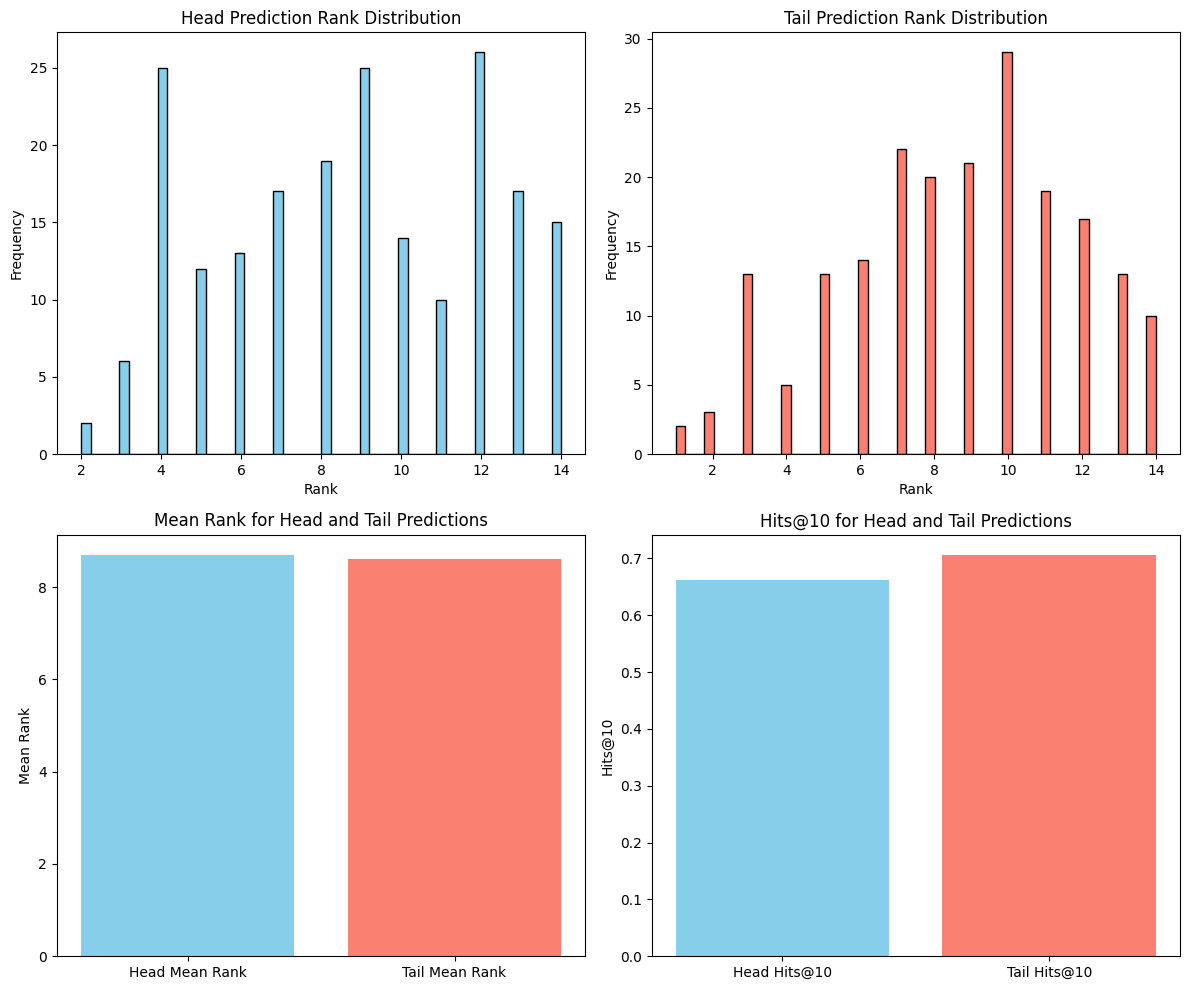


Training TransR on Nations with margin: 3
Epoch 1/50, Margin 3, Loss: 3.6623
Epoch 2/50, Margin 3, Loss: 3.1714
Epoch 3/50, Margin 3, Loss: 2.9373
Epoch 4/50, Margin 3, Loss: 2.6778
Epoch 5/50, Margin 3, Loss: 2.8072
Epoch 6/50, Margin 3, Loss: 2.6461
Epoch 7/50, Margin 3, Loss: 2.5864
Epoch 8/50, Margin 3, Loss: 2.7089
Epoch 9/50, Margin 3, Loss: 2.4029
Epoch 10/50, Margin 3, Loss: 2.4687
Epoch 11/50, Margin 3, Loss: 2.4316
Epoch 12/50, Margin 3, Loss: 2.4448
Epoch 13/50, Margin 3, Loss: 2.4401
Epoch 14/50, Margin 3, Loss: 2.2928
Epoch 15/50, Margin 3, Loss: 2.2843
Epoch 16/50, Margin 3, Loss: 2.3838
Epoch 17/50, Margin 3, Loss: 2.2657
Epoch 18/50, Margin 3, Loss: 2.3694
Epoch 19/50, Margin 3, Loss: 2.1937
Epoch 20/50, Margin 3, Loss: 2.2691
Epoch 21/50, Margin 3, Loss: 2.2439
Epoch 22/50, Margin 3, Loss: 2.2280
Epoch 23/50, Margin 3, Loss: 2.2357
Epoch 24/50, Margin 3, Loss: 2.1851
Epoch 25/50, Margin 3, Loss: 2.2145
Epoch 26/50, Margin 3, Loss: 2.1683
Epoch 27/50, Margin 3, Loss: 2

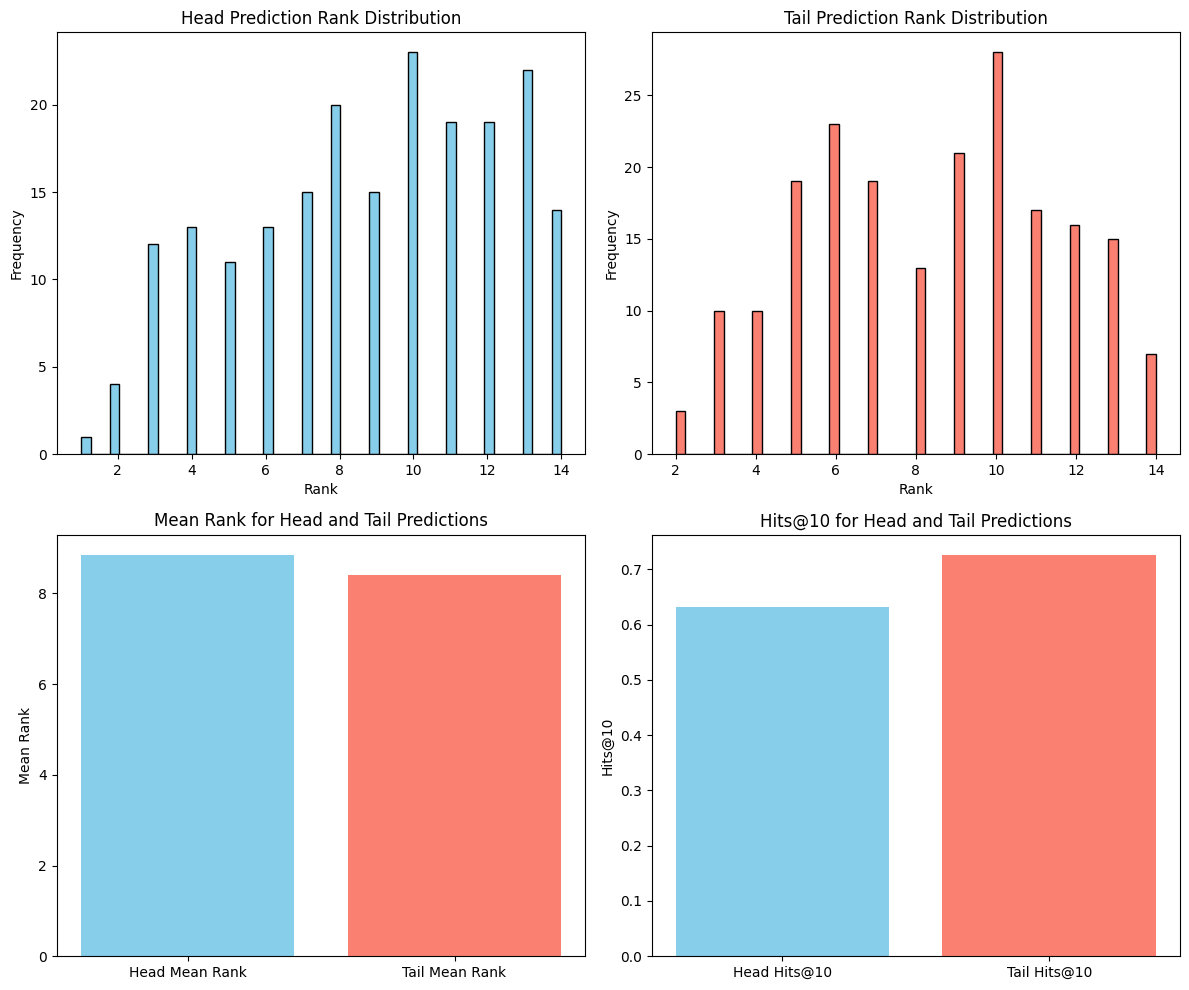


Training TransR on Nations with margin: 4
Epoch 1/50, Margin 4, Loss: 4.6207
Epoch 2/50, Margin 4, Loss: 4.1451
Epoch 3/50, Margin 4, Loss: 3.8626
Epoch 4/50, Margin 4, Loss: 3.5106
Epoch 5/50, Margin 4, Loss: 3.3002
Epoch 6/50, Margin 4, Loss: 3.4309
Epoch 7/50, Margin 4, Loss: 3.3036
Epoch 8/50, Margin 4, Loss: 3.2129
Epoch 9/50, Margin 4, Loss: 3.2035
Epoch 10/50, Margin 4, Loss: 3.1951
Epoch 11/50, Margin 4, Loss: 2.9797
Epoch 12/50, Margin 4, Loss: 2.9301
Epoch 13/50, Margin 4, Loss: 3.1163
Epoch 14/50, Margin 4, Loss: 3.1085
Epoch 15/50, Margin 4, Loss: 3.0958
Epoch 16/50, Margin 4, Loss: 2.9539
Epoch 17/50, Margin 4, Loss: 3.0415
Epoch 18/50, Margin 4, Loss: 2.9005
Epoch 19/50, Margin 4, Loss: 2.7827
Epoch 20/50, Margin 4, Loss: 2.8592
Epoch 21/50, Margin 4, Loss: 2.7984
Epoch 22/50, Margin 4, Loss: 2.9003
Epoch 23/50, Margin 4, Loss: 2.8732
Epoch 24/50, Margin 4, Loss: 2.7786
Epoch 25/50, Margin 4, Loss: 2.8433
Epoch 26/50, Margin 4, Loss: 2.8693
Epoch 27/50, Margin 4, Loss: 2

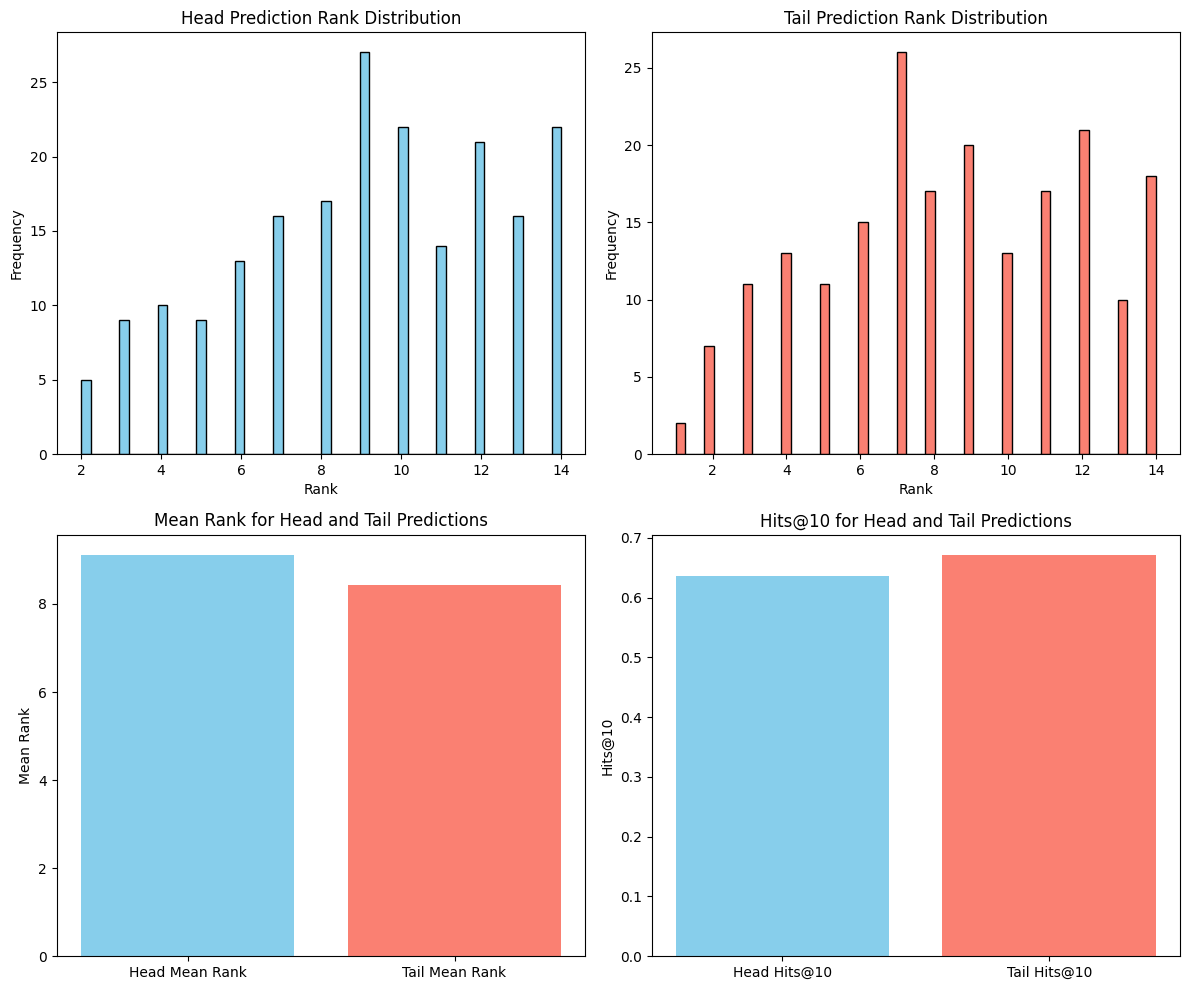


Training TransR on Nations with margin: 5
Epoch 1/50, Margin 5, Loss: 5.5729
Epoch 2/50, Margin 5, Loss: 4.9763
Epoch 3/50, Margin 5, Loss: 4.6712
Epoch 4/50, Margin 5, Loss: 4.4833
Epoch 5/50, Margin 5, Loss: 4.1763
Epoch 6/50, Margin 5, Loss: 4.0261
Epoch 7/50, Margin 5, Loss: 4.0548
Epoch 8/50, Margin 5, Loss: 4.0670
Epoch 9/50, Margin 5, Loss: 4.0355
Epoch 10/50, Margin 5, Loss: 4.0695
Epoch 11/50, Margin 5, Loss: 3.8036
Epoch 12/50, Margin 5, Loss: 3.7509
Epoch 13/50, Margin 5, Loss: 3.6550
Epoch 14/50, Margin 5, Loss: 3.8309
Epoch 15/50, Margin 5, Loss: 3.6791
Epoch 16/50, Margin 5, Loss: 3.6731
Epoch 17/50, Margin 5, Loss: 3.6098
Epoch 18/50, Margin 5, Loss: 3.5610
Epoch 19/50, Margin 5, Loss: 3.4475
Epoch 20/50, Margin 5, Loss: 3.5151
Epoch 21/50, Margin 5, Loss: 3.5441
Epoch 22/50, Margin 5, Loss: 3.4592
Epoch 23/50, Margin 5, Loss: 3.5936
Epoch 24/50, Margin 5, Loss: 3.4267
Epoch 25/50, Margin 5, Loss: 3.4763
Epoch 26/50, Margin 5, Loss: 3.3454
Epoch 27/50, Margin 5, Loss: 3

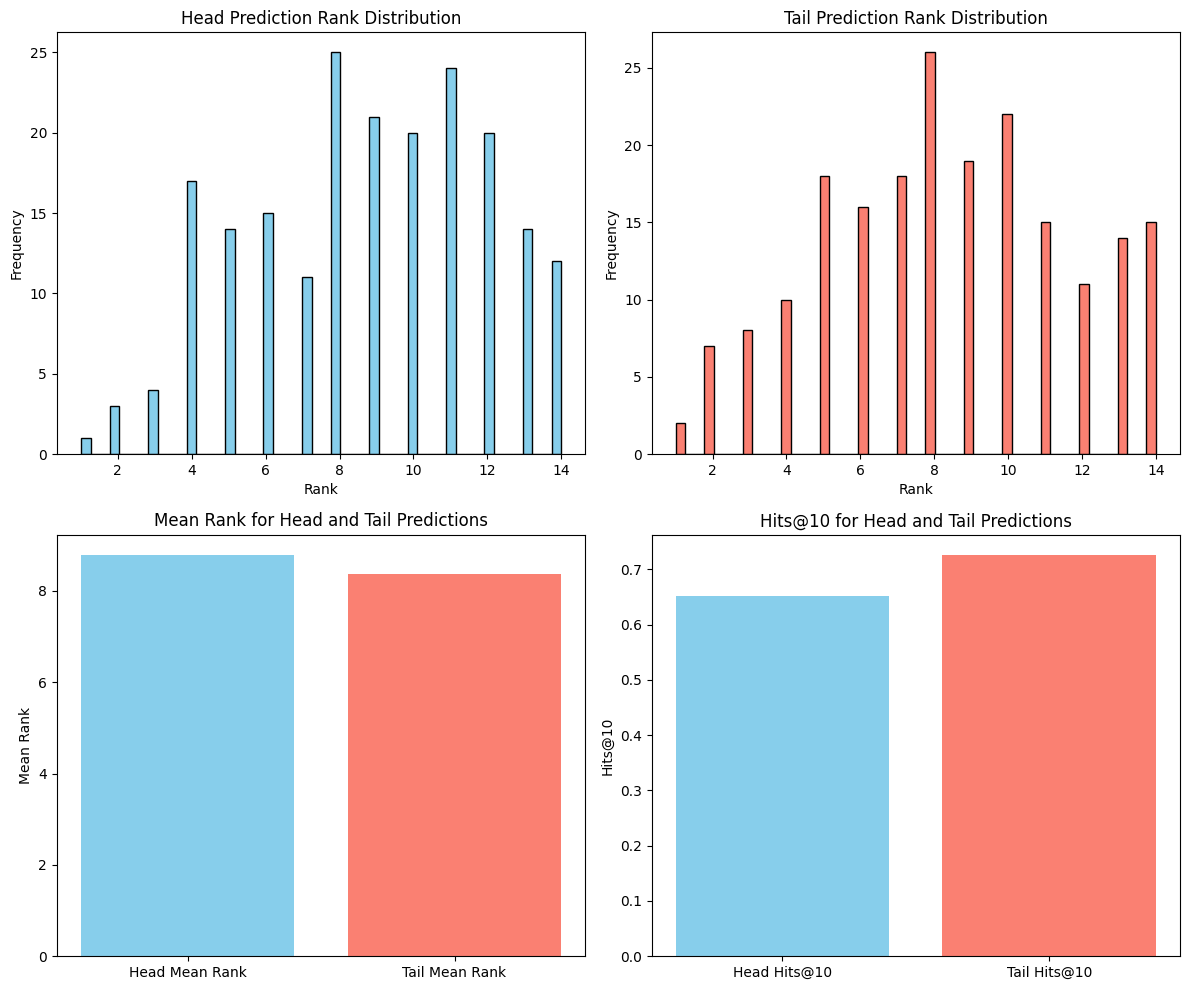


TransR training on Nations completed.


In [ ]:
# Training loop with margin values 1 to 5
for margin in range(1, 6):
    print(f"\nTraining TransR on Nations with margin: {margin}")

    # Define TransR model
    trans_r_model = TransR(
        num_entities=nations_dataset.num_entities,
        num_relations=nations_dataset.num_relations,
        embedding_dim=embedding_dim,
        proj_dim=proj_dim,
        margin=margin,
        norm=1
    ).to(device)

    # Optimizer
    optimizer = torch.optim.Adam(trans_r_model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        trans_r_model.train()

        # Shuffle and batch the training triples
        indices = torch.randperm(nations_train_triples.size(0))
        epoch_loss = 0.0

        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            positive_batch = nations_train_triples[batch_indices]
            negative_batch = negative_sampler.sample(positive_batch).to(device)

            # Forward pass and loss calculation
            optimizer.zero_grad()
            loss = trans_r_model(positive_batch, negative_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        num_batches = max(1, len(indices) // batch_size)
        print(f"Epoch {epoch + 1}/{epochs}, Margin {margin}, Loss: {epoch_loss / num_batches:.4f}")

    # Evaluating model
    transR_nations_results = head_tail_prediction(trans_r_model, nations_test_triples, nations_dataset.num_entities, device)



print("\nTransR training on Nations completed.")

**NEXT WE WILL PERFORM TransE and TransR training and comparisons using the Kinships Dataset:**

In [22]:
# Load the Kinships dataset
kinships_dataset = datasets.Kinships()
kinships_train_triples = kinships_dataset.training.mapped_triples.to(device)
kinships_valid_triples = kinships_dataset.validation.mapped_triples.to(device)
kinships_test_triples = kinships_dataset.testing.mapped_triples.to(device)

print("Kinships dataset loaded")
print("Training triples:", kinships_train_triples.shape)
print("Validation triples:", kinships_valid_triples.shape)
print("Testing triples:", kinships_test_triples.shape)

Kinships dataset loaded
Training triples: torch.Size([8544, 3])
Validation triples: torch.Size([1068, 3])
Testing triples: torch.Size([1074, 3])


In [23]:
kinships_relation_probabilities = calculate_relation_probabilities(kinships_train_triples)

In [24]:
negative_sampler_kinships = CustomBernoulliNegativeSampler(kinships_train_triples, kinships_relation_probabilities)

In [25]:
# Parameters for Kinships dataset
embedding_dim = 100
learning_rate = 0.001
epochs = 10
batch_size = 512

Epoch 1/10, Loss: 2.4606
Epoch 2/10, Loss: 2.3583
Epoch 3/10, Loss: 2.3420
Epoch 4/10, Loss: 2.2930
Epoch 5/10, Loss: 2.2342
Epoch 6/10, Loss: 2.1392
Epoch 7/10, Loss: 2.0515
Epoch 8/10, Loss: 2.0829
Epoch 9/10, Loss: 2.0880
Epoch 10/10, Loss: 2.0300

Head Prediction - Mean Rank: 53.08379888268156, Hits@10: 0.08845437616387337
Tail Prediction - Mean Rank: 53.312849162011176, Hits@10: 0.07635009310986965


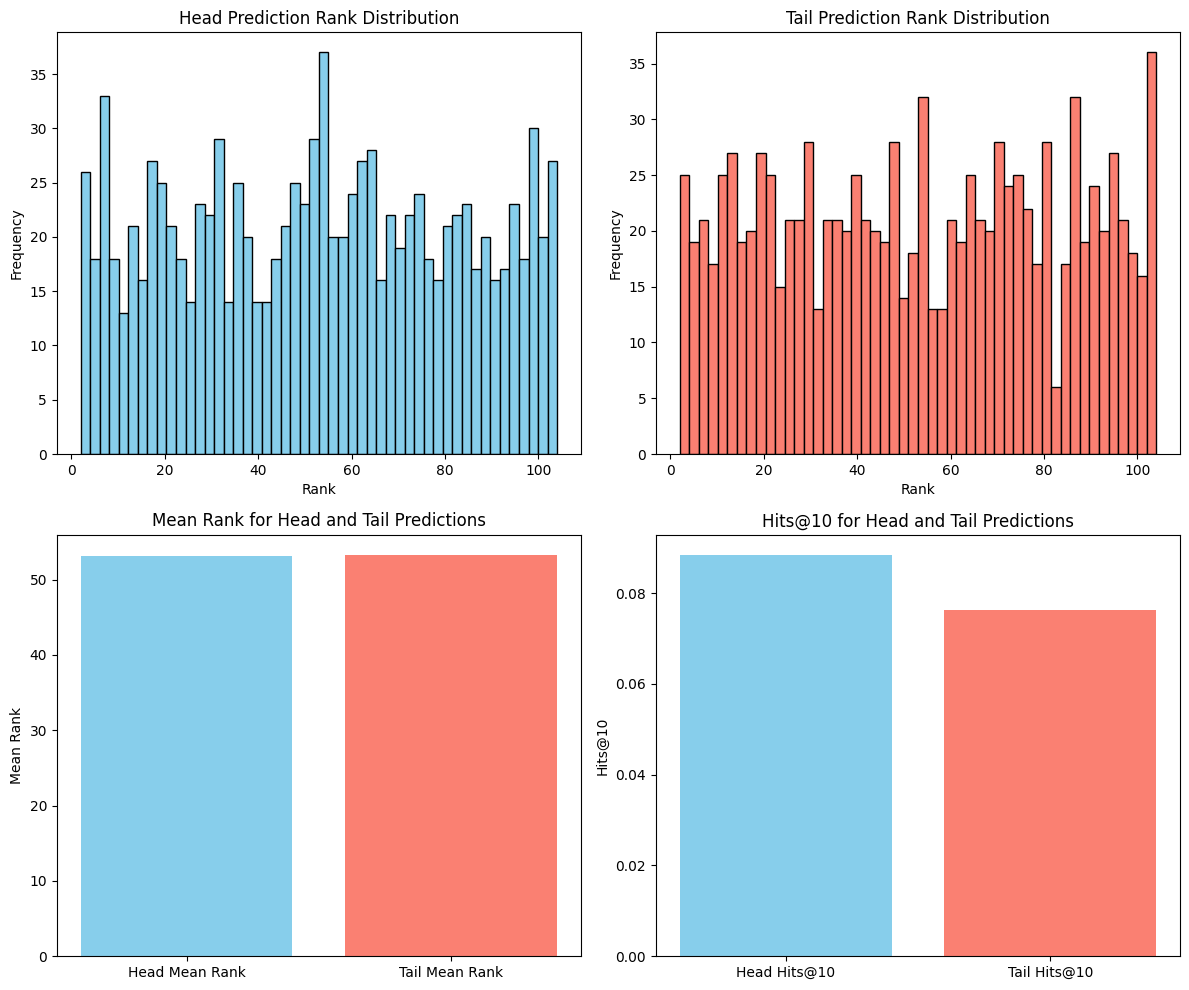

In [26]:
# Define TransE model
trans_e_model = TransE(
    num_entities=kinships_dataset.num_entities,
    num_relations=kinships_dataset.num_relations,
    embedding_dim=embedding_dim,
    margin=1,  # Use margin = 1
    norm=1
).to(device)

# Optimizer
optimizer = torch.optim.Adam(trans_e_model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    trans_e_model.train()

    # Shuffle and batch the training triples
    indices = torch.randperm(kinships_train_triples.size(0))
    epoch_loss = 0.0

    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        positive_batch = kinships_train_triples[batch_indices]
        negative_batch = negative_sampler_kinships.sample(positive_batch).to(device)

        # Forward pass and loss calculation
        optimizer.zero_grad()
        loss = trans_e_model(positive_batch, negative_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    num_batches = max(1, len(indices) // batch_size)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / num_batches:.4f}")

# Model evaluation
transE_kinships_results = head_tail_prediction(trans_e_model, kinships_test_triples, kinships_dataset.num_entities, device)



Epoch 1/10, Loss: 1.2632
Epoch 2/10, Loss: 1.0042
Epoch 3/10, Loss: 0.8549
Epoch 4/10, Loss: 0.7544
Epoch 5/10, Loss: 0.7008
Epoch 6/10, Loss: 0.6353
Epoch 7/10, Loss: 0.5870
Epoch 8/10, Loss: 0.5455
Epoch 9/10, Loss: 0.4962
Epoch 10/10, Loss: 0.4861

Head Prediction - Mean Rank: 40.283054003724395, Hits@10: 0.16945996275605213
Tail Prediction - Mean Rank: 35.03631284916201, Hits@10: 0.17690875232774675


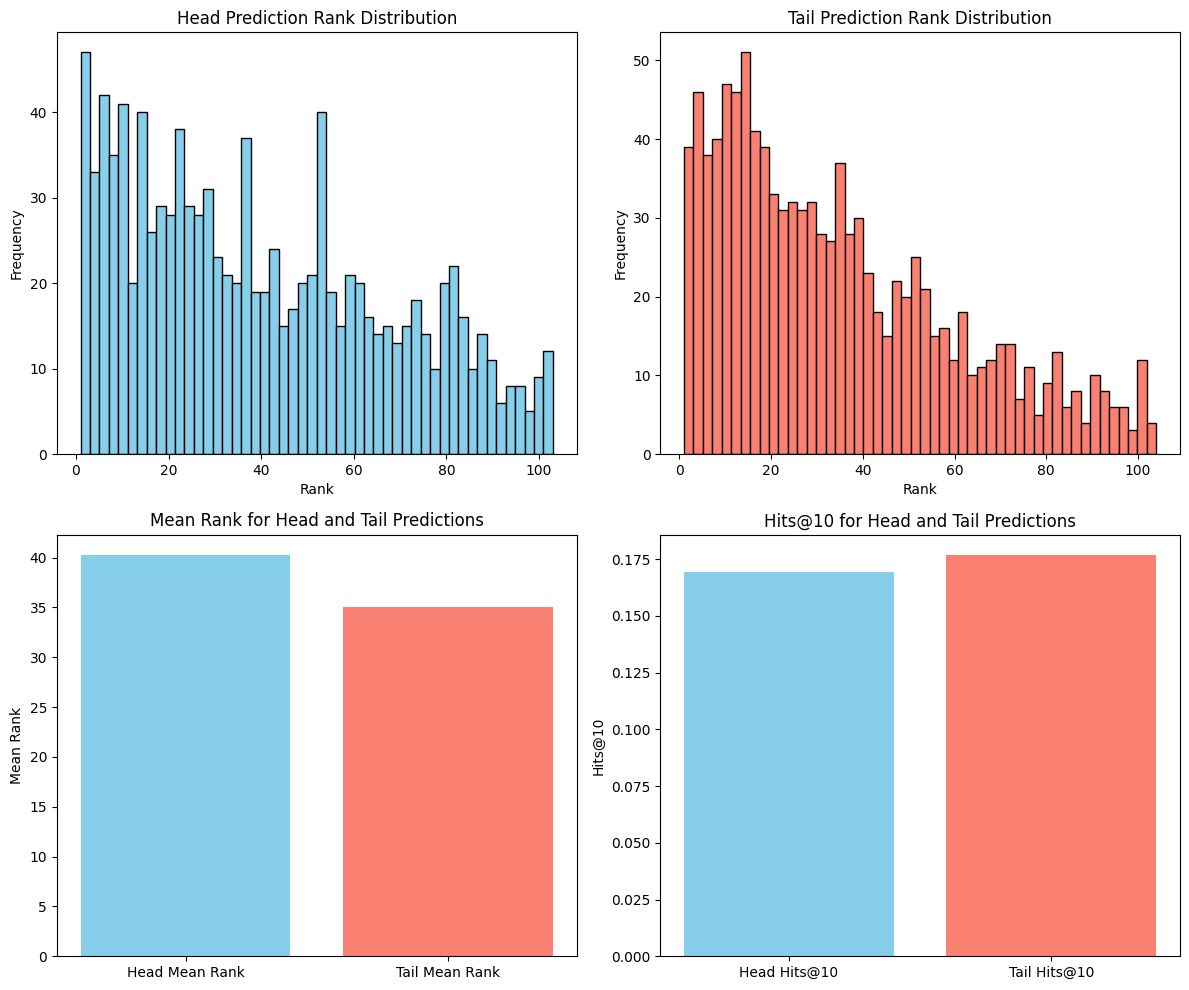

In [ ]:
# Define TransR model
trans_r_model = TransR(
    num_entities=kinships_dataset.num_entities,
    num_relations=kinships_dataset.num_relations,
    embedding_dim=embedding_dim,
    proj_dim=proj_dim,
    margin=1,  # Use margin = 1
    norm=1
).to(device)

# Optimizer
optimizer = torch.optim.Adam(trans_r_model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    trans_r_model.train()

    # Shuffle and batch the training triples
    indices = torch.randperm(kinships_train_triples.size(0))
    epoch_loss = 0.0

    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        positive_batch = kinships_train_triples[batch_indices]
        negative_batch = negative_sampler_kinships.sample(positive_batch).to(device)

        # Forward pass and loss calculation
        optimizer.zero_grad()
        loss = trans_r_model(positive_batch, negative_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    num_batches = max(1, len(indices) // batch_size)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / num_batches:.4f}")


transR_kinships_results = head_tail_prediction(trans_r_model, kinships_test_triples, kinships_dataset.num_entities, device)

# **PART B :-**

**SIMILAR FACT RETRIEVAL PART**

In [ ]:
!pip install pykeen torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
# Import required libraries
import torch
from pykeen.pipeline import pipeline
from pykeen.datasets import Nations
import torch.nn.functional as F
from typing import List, Tuple, Dict

INFO:pykeen.utils:Using opt_einsum


In [ ]:
# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load the Nations dataset
dataset = Nations()

# Define validation triples
validation_triples = [
    ('brazil', 'commonbloc1', 'india'),
    ('burma', 'intergovorgs3', 'indonesia'),
    ('china', 'accusation', 'uk'),
    ('cuba', 'reldiplomacy', 'china'),
    ('egypt', 'embassy', 'uk')
]

In [ ]:
def train_model(model_name: str, embedding_dim: int = 30) -> Tuple[dict, dict, dict]:
    """
    Train either TransE or TransR model on the Nations dataset using GPU acceleration
    """
    model_kwargs = {
        'embedding_dim': embedding_dim,
        'random_seed': 42
    }

    # Add specific kwargs for TransR
    if model_name == 'TransR':
        model_kwargs['relation_dim'] = embedding_dim  # Set relation dimension

    result = pipeline(
        dataset=dataset,
        model=model_name,
        model_kwargs=model_kwargs,
        training_kwargs={
            'num_epochs': 100,
            'batch_size': 256,
            'use_tqdm': True
        },
        device=device,
        random_seed=42
    )

    return result.model, dataset.entity_to_id, dataset.relation_to_id

In [ ]:
def get_embeddings(model, indices: torch.Tensor, embedding_type: str = 'entity') -> torch.Tensor:
    """
    Safely get embeddings from the model
    """
    if embedding_type == 'entity':
        return model.entity_representations[0](indices.to(device))
    else:
        return model.relation_representations[0](indices.to(device))

def get_model_dim(model) -> Tuple[int, int]:
    """
    Get entity and relation embedding dimensions for the model
    """
    # Create dummy indices to get embedding dimensions
    dummy_entity_idx = torch.tensor([0], device=device)
    dummy_relation_idx = torch.tensor([0], device=device)

    # Get sample embeddings to determine dimensions
    entity_emb = get_embeddings(model, dummy_entity_idx, 'entity')
    relation_emb = get_embeddings(model, dummy_relation_idx, 'relation')

    return entity_emb.size(-1), relation_emb.size(-1)

def get_triple_embedding(model, triple: Tuple[str, str, str],
                        entity_to_id: Dict[str, int],
                        relation_to_id: Dict[str, int]) -> torch.Tensor:
    """
    Get the embedding of a triple using the trained model
    """
    # Convert string labels to indices
    head_idx = torch.tensor([entity_to_id[triple[0]]], dtype=torch.long, device=device)
    rel_idx = torch.tensor([relation_to_id[triple[1]]], dtype=torch.long, device=device)
    tail_idx = torch.tensor([entity_to_id[triple[2]]], dtype=torch.long, device=device)

    with torch.no_grad():
        # Get embeddings
        head_emb = get_embeddings(model, head_idx, 'entity')
        rel_emb = get_embeddings(model, rel_idx, 'relation')
        tail_emb = get_embeddings(model, tail_idx, 'entity')

        if isinstance(model, torch.nn.Module) and hasattr(model, 'relation_representations') and len(model.relation_representations) > 1:  # TransR
            # Get projection matrix
            projection = model.relation_representations[1](rel_idx)
            # Get dimensions
            entity_dim = head_emb.size(-1)
            relation_dim = rel_emb.size(-1)
            # Reshape for projection
            projection = projection.view(-1, entity_dim, relation_dim)
            # Apply projection
            head_emb = torch.bmm(head_emb.unsqueeze(1), projection).squeeze(1)
            tail_emb = torch.bmm(tail_emb.unsqueeze(1), projection).squeeze(1)

        # Concatenate embeddings
        return torch.cat([head_emb, rel_emb, tail_emb], dim=1)

In [ ]:
def retrieve_similar_triples(model, validation_triples: List[Tuple[str, str, str]],
                           entity_to_id: Dict[str, int],
                           relation_to_id: Dict[str, int],
                           k: int = 5) -> Dict[Tuple[str, str, str], List[Tuple[Tuple[str, str, str], float]]]:
    """
    Retrieve k most similar triples for each validation triple
    """
    # Create reverse mappings
    id_to_entity = {v: k for k, v in entity_to_id.items()}
    id_to_relation = {v: k for k, v in relation_to_id.items()}

    # Convert training triples to indices
    training_triples_tensor = dataset.training.mapped_triples.to(device)

    results = {}
    batch_size = 128

    # Process each validation triple
    for val_triple in validation_triples:
        # Get embedding for validation triple
        val_emb = get_triple_embedding(model, val_triple, entity_to_id, relation_to_id)

        similarities = []

        # Process training triples in batches
        num_triples = len(training_triples_tensor)
        for start_idx in range(0, num_triples, batch_size):
            end_idx = min(start_idx + batch_size, num_triples)
            batch_triples = training_triples_tensor[start_idx:end_idx]

            # Get embeddings for batch
            with torch.no_grad():
                # Get embeddings
                head_emb = get_embeddings(model, batch_triples[:, 0], 'entity')
                rel_emb = get_embeddings(model, batch_triples[:, 1], 'relation')
                tail_emb = get_embeddings(model, batch_triples[:, 2], 'entity')

                if isinstance(model, torch.nn.Module) and hasattr(model, 'relation_representations') and len(model.relation_representations) > 1:  # TransR
                    # Get projection matrix
                    projection = model.relation_representations[1](batch_triples[:, 1])
                    # Get dimensions
                    entity_dim = head_emb.size(-1)
                    relation_dim = rel_emb.size(-1)
                    # Reshape for projection
                    projection = projection.view(-1, entity_dim, relation_dim)
                    # Apply projection
                    head_emb = torch.bmm(head_emb.unsqueeze(1), projection).squeeze(1)
                    tail_emb = torch.bmm(tail_emb.unsqueeze(1), projection).squeeze(1)

                # Concatenate embeddings
                batch_emb = torch.cat([head_emb, rel_emb, tail_emb], dim=1)

            # Compute similarities
            batch_sims = F.cosine_similarity(
                val_emb.expand(len(batch_triples), -1),
                batch_emb,
                dim=1
            )

            # Store results
            for idx, sim in enumerate(batch_sims):
                triple_idx = batch_triples[idx]
                h, r, t = triple_idx.tolist()

                if (h, r, t) != (entity_to_id[val_triple[0]],
                                relation_to_id[val_triple[1]],
                                entity_to_id[val_triple[2]]):
                    triple_labels = (
                        id_to_entity[h],
                        id_to_relation[r],
                        id_to_entity[t]
                    )
                    similarities.append((triple_labels, sim.item()))

        # Sort and get top k
        similarities.sort(key=lambda x: x[1], reverse=True)
        results[val_triple] = similarities[:k]

    return results

In [ ]:
def main():
    try:
        # Clear GPU cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # Train models
        print("Training TransE model...")
        transe_model, entity_to_id, relation_to_id = train_model('TransE')
        print("Training TransR model...")
        transr_model, _, _ = train_model('TransR')

        # Get and print results
        print("\nTransE Results:")
        transe_results = retrieve_similar_triples(transe_model, validation_triples,
                                                entity_to_id, relation_to_id)

        for val_triple, similar_triples in transe_results.items():
            print(f"\nValidation triple: {val_triple}")
            for triple, similarity in similar_triples:
                print(f"Similar triple: {triple}, Similarity: {similarity:.4f}")

        print("\nTransR Results:")
        transr_results = retrieve_similar_triples(transr_model, validation_triples,
                                                entity_to_id, relation_to_id)

        for val_triple, similar_triples in transr_results.items():
            print(f"\nValidation triple: {val_triple}")
            for triple, similarity in similar_triples:
                print(f"Similar triple: {triple}, Similarity: {similarity:.4f}")

    except Exception as e:
        print(f"Error: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()